# Calibration and uncertainty analysis - virtual experiment
      

In [90]:
import numpy as np
import matplotlib.pyplot as pl
from scipy import stats
%matplotlib inline

pl.rcParams['figure.figsize'] = 10, 8 
pl.rcParams['font.size'] = 18

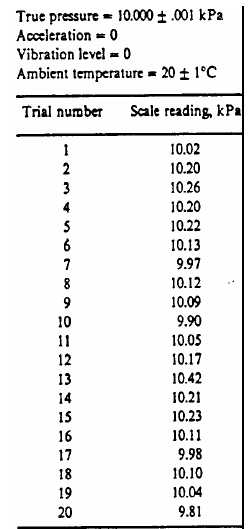

In [91]:
from IPython.display import Image
Image('img/pressure_calibration_table.png')

In [110]:
ptrue = 10.000
p = np.array([10.02, 10.20, 10.26, 10.20, 10.22, 10.13, 9.97, 10.12, 
              10.09, 9.9, 10.05, 10.17, 10.42, 10.21, 10.23, 10.11, 9.98, 10.10, 10.04, 9.81])
print p

[ 10.02  10.2   10.26  10.2   10.22  10.13   9.97  10.12  10.09   9.9
  10.05  10.17  10.42  10.21  10.23  10.11   9.98  10.1   10.04   9.81]


## Recommendations for choice of the histogram size:


Let's build *histogram*, we need to select the number of bins or $\Delta p$


$k$ or number of bins shall be at least 5:

$k \geq 5$

There are several different methods to estimate the right number of bins for the histogram:
    
$K = 1.87(N-1)^{0.4} + 1$
    
or 


$K = N^{1/2}$


histogram is defined as: 
    $ Z = \frac{n(y)}{N \Delta y}$ 
    
where $\Delta y$ bin size, $N$ total number of readings, $n(y)$ is the number of readings in some bin, centered at $y$
    

In [93]:
K = 1.87*(p.size - 1)**(0.4); print K
K = np.sqrt(p.size); print K
K = 9 
dp = (np.max(p) - np.min(p))/K; print dp
bins = np.r_[np.min(p)-dp:np.max(p)+dp:dp]; print bins # row vector 

6.07215776742
4.472135955
0.0677777777778
[  9.74222222   9.81         9.87777778   9.94555556  10.01333333
  10.08111111  10.14888889  10.21666667  10.28444444  10.35222222  10.42      ]


In [94]:
hist, bin_edges = np.histogram(p,bins=bins)
hist

array([0, 1, 1, 2, 3, 5, 4, 3, 0, 1])

<Container object of 10 artists>

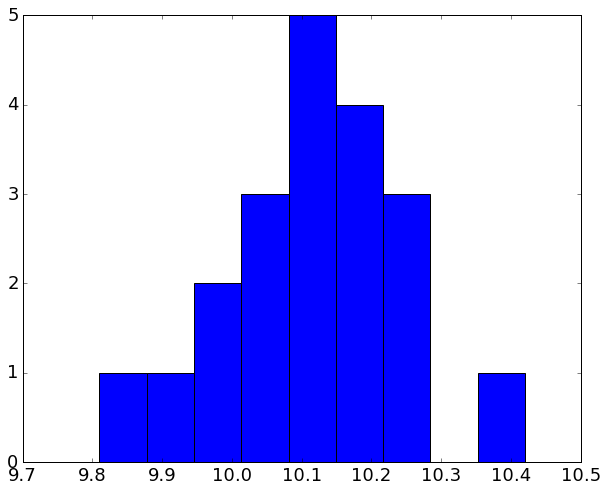

In [95]:
pl.bar(bin_edges[:-1], hist, dp)

### we expect to see the Gaussian, if our pressure measurements contain random errors

$$ f(x) = \frac{1}{\sqrt{2\pi \sigma^2}} e^{-\frac{(X-\mu)^2}{2\sigma^2}} $$



In [96]:
mu = np.mean(p)
sigma = np.std(p)
print 'mean, std %3.2f, %3.2f' % (mu, sigma)
x = np.linspace(9.7,10.5,100)
gauss = 1./np.sqrt(2*np.pi*sigma**2)*np.exp(-((x-mu)**2/(2*sigma**2)))

mean, std 10.11, 0.13


(9.5, 10.6)

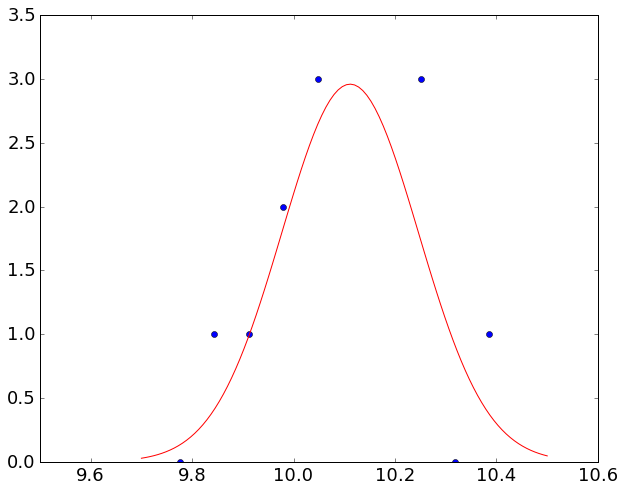

In [97]:
pl.plot(bin_edges[:-1]+dp/2,hist,'bo',x,gauss,'r')
pl.ylim(0,3.5)
pl.xlim(9.5, 10.6)

### $\chi^2$ test 

How do we check if our histogram is similar to the Gaussian (or any other) distribution? Goodness-of-fit is called the $\chi^2$ test

$\chi^2 = \sum\limits_{i=1}^{n} \frac{(measured_i - expected_i)^2}{expected_i} $

In [98]:
gauss = 1./np.sqrt(2*np.pi*sigma**2)*np.exp(-((bin_edges[:-1]+dp/2.-mu)**2/(2*sigma**2)))
chisq = np.sum((hist - gauss)**2/gauss)
print '$\chi^2$ = %f' % chisq

$\chi^2$ = 6.126602


In [99]:
# degrees of freedom = number of bins minus the (order of the fit + 1):
print 'Number of degrees of freedom,  K - (m+1) = %d' % (K - 2)

Number of degrees of freedom,  K - (m+1) = 7


Confidence level is 52.5 percent


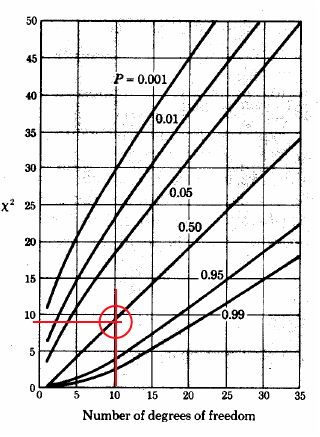

In [100]:
from scipy import stats
pval = 1 - stats.chi2.cdf(chisq, K-2); print 'Confidence level is %3.1f percent' % (pval*100)  
Image('img/chi_square_graph.png')

#### we conclude that for the given set of measurements we are only 50% certain that we can use the Gaussian distribution assumptions

## Calibration

In [101]:
# Increasing pressure:
p_in_up = np.linspace(0.0,10.0,11)
p_out_up = np.array([-1.12, 0.21, 1.18, 2.09, 3.33, 4.50, 5.26, 6.59, 7.73, 8.68, 9.8])

In [102]:
# Decreasing pressure
p_in_down = np.flipud(p_in_up)
p_out_down = np.array([10.20, 9.10, 7.92, 6.89, 5.87, 4.71, 3.62, 2.48, 1.65, 0.42, -0.69])

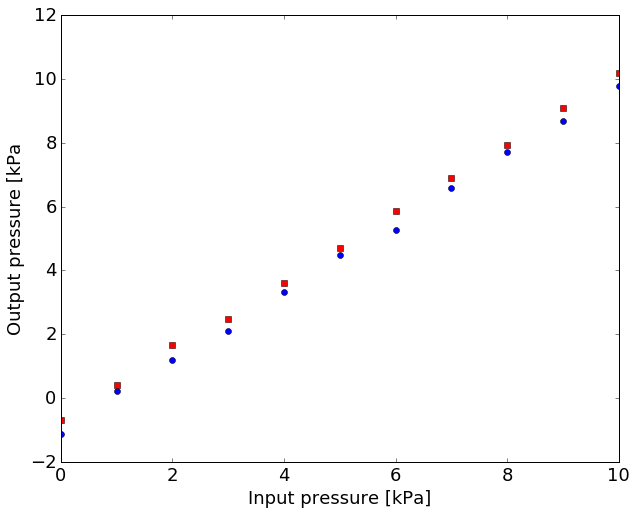

In [103]:
pl.plot(p_in_up,p_out_up,'bo',p_in_down,p_out_down,'rs')
pl.xlabel('Input pressure [kPa]')
pl.ylabel('Output pressure [kPa')

In [104]:
x = np.r_[p_in_up,p_in_down]
y = np.r_[p_out_up,p_out_down]

In [105]:
 np.polyfit(x,y,1)

array([ 1.08231818, -0.84704545])

## Estimate uncertainty
$q_0 = m q_i + b$

$q_0 = 1.08 q_i + 0.85$ 

$\sigma_{q_0}^2 = \frac{1}{N} \sum (m q_i + b - q_0)$  

We then use the inverse of the calibration curve to get the inputs from the outputs:

$q_i = \frac{q_0 - b}{m}$


$\sigma_{q_i}^2 = \frac{1}{N} \sum \left( \frac{q_0 - b}{m} - q_i \right)^2 = \frac{\sigma_{q_0}^2}{m^2} $





In [106]:
m = 1.08
b = -0.85
std_q0 = np.sqrt(1./(y.size-1) * np.sum((m*x + b - y)**2))
print 'std(q_0) = %f ' % std_q0

std(q_0) = 0.203727 


In [107]:
# let's assume we measured output
q_0 = 4.32 #kPa
# we estimate the real input as:
q_i = (q_0 - b)/m

# and its std. dev.

std_qi = std_q0/m

print 'q_i = %3.2f +- %3.2f kPa ' % (q_i, 3*std_qi)

q_i = 4.79 +- 0.57 kPa 


In [108]:
# we can visualize the result as:
Image('img/result_pressure_measurement.png');

### Uncertainties of least-square best fit estimates:

$S_y^2 = \frac{1}{N-1} \sum\limits_{i=1}^N (y_i - \overline{y})^2 $

$S_{yx}^2 = \frac{1}{\nu} \sum\limits_{i=1}^N (y_i - \overline{y_{c_i}})^2$ 

$\nu = N - (m+1)$

$S_m = S_{yx}^2 \frac{N}{N\sum\limits_{i=1}^N x_i^2 - \left( \sum\limits_{i=1}^N x_i \right)^2} $


$S_b = S_{yx}^2 \frac{N\sum\limits_{i=1}^N x_i^2}{N \left[N\sum\limits_{i=1}^N x_i^2 - \left( \sum\limits_{i=1}^N x_i \right)^2 \right]} $

$S_m = 0.0134$ - sensitivity uncertainty

$S_b = 0.078$ - zero shift uncertainty

$ m = 1.08 \pm 0.04$ 

$ b = -0.85 \pm 0.24 $ kPa